In [ ]:
# Setup chunk to install and load required packages
knitr::opts_chunk$set(warning = FALSE, message = FALSE)
suppressWarnings(if(!require("pacman")) install.packages("pacman"))

pacman::p_load('tidyverse', 'tidymodels', 'glmnet',
               'randomForest', 'xgboost','patchwork',
               'paletteer', 'here', 'doParallel', 'summarytools')

## **Regression - Optimize and save models**

In the previous notebook, we used a linear regression model to look at the relationship between features of a bike rentals dataset.
In this notebook, we'll see if we can improve the performance of these models even further.

Let's begin by loading the bicycle sharing data as a tibble and viewing the first few rows.
We'll also split our data into training and test datasets.

In [1]:
# Load the required packages and make them available in your current R session
suppressPackageStartupMessages({
  library(tidyverse)
  library(tidymodels)
  library(lubridate)
  library(paletteer)
})

# Import the data into the R session
bike_data <- read_csv(file = 
"https://raw.githubusercontent.com/MicrosoftDocs/ml-basics/master/data/daily-bike-share.csv", 
show_col_types = FALSE)

# Parse dates then extract days
bike_data <- bike_data %>%
  mutate(dteday = mdy(dteday)) %>% 
  mutate(day = day(dteday))

# Select desired features and labels
bike_select <- bike_data %>% 
  select(c(season, mnth, holiday, weekday, workingday, weathersit,
           temp, atemp, hum, windspeed, rentals)) %>% 
  mutate(across(1:6, factor))

# Split 70% of the data for training and the rest for tesing
set.seed(2056)
bike_split <- bike_select %>% 
  initial_split(prop = 0.7,
  # splitting data evenly on the holiday variable
                strata = holiday)

# Extract the data in each split
bike_train <- training(bike_split)
bike_test <- testing(bike_split)

# Specify multiple regression metrics
eval_metrics <- metric_set(rmse, rsq)


cat("Training Set", nrow(bike_train), "rows",
    "\nTest Set", nrow(bike_test), "rows")

Training Set 511 rows 
Test Set 220 rows

This results into the following two datasets:

-   *bike_train*: subset of the dataset used to train the model.

-   *bike_test*: subset of the dataset used to validate the model.

Now we're ready to train another regression model and a boosted tree model and then compare their performance.
Recall that a Gradient Boosting estimator, is like a Random Forest algorithm, but instead of building them all trees independently and taking the average result, each tree is built on the outputs of the previous one in an attempt to incrementally reduce the *loss* (error) in the model.

In [2]:
# Build a linear model specification
lm_spec <- 
  # Type
  linear_reg() %>% 
  # Engine
  set_engine("lm") %>% 
  # Mode
  set_mode("regression")

### Preprocess the Data using recipes

We trained a model with data that was loaded straight from a source file, with only moderately successful results.
In practice, it's common to perform some preprocessing of the data to make it easier for the algorithm to fit a model to it.

In this section, we'll explore another tidymodels package, [recipes](https://tidymodels.github.io/recipes/), which is designed to help you preprocess your data *before* training your model.
A recipe is an object that defines a series of steps for data processing.

There's a huge range of preprocessing transformations you can perform to get your data ready for modeling, but we'll limit ourselves to a few common techniques:

#### Scaling numeric features

Normalizing numeric features so they're on the same scale prevents features with large values from producing coefficients that disproportionately affect the predictions.
For example, suppose your data includes the following numeric features:

|  A  |  B  |  C  |
|:---:|:---:|:---:|
|  3  | 480 | 65  |

Normalizing these features to the same scale may result in the following values (assuming A contains values from 0 to 10, B contains values from 0 to 1000, and C contains values from 0 to 100):

|  A  |  B   |  C   |
|:---:|:----:|:----:|
| 0.3 | 0.48 | 0.65 |

There are multiple ways you can scale numeric data, such as calculating the minimum and maximum values for each column and assigning a proportional value between 0 and 1, or by using the mean and standard deviation of a normally distributed variable to maintain the same *spread* of values on a different scale.

#### Encoding categorical variables

This involves translating a column with categorical values into one or more numeric columns that take the place of the original.

Machine learning models work best with numeric features rather than text values, so you generally need to convert categorical features into numeric representations.
For example, suppose your data includes the following categorical feature.

| Size |
|:----:|
|  S   |
|  M   |
|  L   |

You can apply *ordinal encoding* to substitute a unique integer value for each category, like this:

| Size |
|:----:|
|  0   |
|  1   |
|  2   |

Another common technique is to create *`dummy`* or`indicator variables` which replace the original categorical feature with numeric columns whose values are either 1 or 0.
This can be shown as:

| Raw Data |  M  |  L  |
|:--------:|:---:|:---:|
|    S     |  0  |  0  |
|    M     |  1  |  0  |
|    L     |  0  |  1  |

In R, the convention is to *exclude* a column for the first factor level (`S`, in this case).
The reasons for this include `simplicity` and reducing `linear dependencies`.
The full set of encodings can also be used for some models.
This is traditionally called the "one-hot" encoding and can be achieved using the `one_hot` argument of `step_dummy()`.

> Tree based models created using the xgboost engine typically require one to create dummy variables.

Now, let's bike forth and create some recipes ​🔪​**🚴!**

In [3]:
# Create recipe
lr_recipe <- recipe(rentals ~ ., data = bike_train) %>% 
  # Create indicator variables
  step_dummy(all_nominal_predictors()) %>% 
  # Filter out zero variance predictors
  step_nzv(all_predictors()) %>% 
  # Center and scale numeric predictors
  step_normalize(all_numeric_predictors()) %>% 
  step_interact( ~ atemp:starts_with("weekday"):starts_with("season")) %>% 
# Reduce correlation among predictors
  step_corr(all_numeric_predictors()) 



# Summary of the recipe
summary(lr_recipe)

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
season,nominal,predictor,original
mnth,nominal,predictor,original
holiday,nominal,predictor,original
weekday,nominal,predictor,original
workingday,nominal,predictor,original
weathersit,nominal,predictor,original
temp,numeric,predictor,original
atemp,numeric,predictor,original
hum,numeric,predictor,original


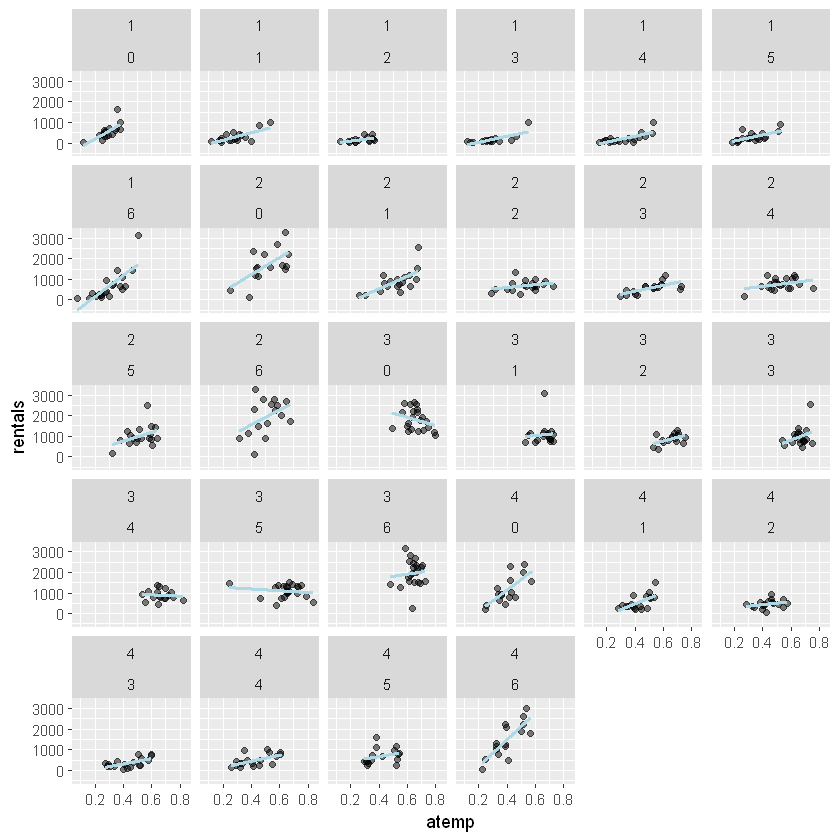

In [4]:
# Explore interactions
bike_train %>% 
  ggplot(mapping = aes(x = atemp, y = rentals)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = lm, formula = y ~ x, se = FALSE, color = "lightblue") + 
  
  facet_wrap(vars(season, weekday))

In [26]:
lr_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         10

Operations:

Dummy variables from all_nominal_predictors()
Sparse, unbalanced variable filter on all_predictors()
Centering and scaling for all_numeric_predictors()
Interactions with atemp:starts_with("weekday"):starts_with("season")
Correlation filter on all_numeric_predictors()

### Bundling it all together using a workflow

The [**workflows**](https://workflows.tidymodels.org/) package allows the user to bind modeling and preprocessing objects together.
You can then fit the entire workflow to the data, so that the model encapsulates all of the preprocessing steps as well as the algorithm.

In [5]:
# Workflow 
lr_wf <- workflow() %>% 
  add_recipe(lr_recipe) %>% 
  add_model(lm_spec)

lr_wf

== Workflow ====================================================================
Preprocessor: Recipe
Model: linear_reg()

-- Preprocessor ----------------------------------------------------------------
5 Recipe Steps

* step_dummy()
* step_nzv()
* step_normalize()
* step_interact()
* step_corr()

-- Model -----------------------------------------------------------------------
Linear Regression Model Specification (regression)

Computational engine: lm 


## Evaluating model performance using resamples



If the test set should not be used immediately, and repredicting the training set is a bad idea, what should be done? Resampling methods, such as cross-validation or validation sets, are the solution.


Resampling estimates of performance can generalize to new data in a similar way as estimates from a test set.

Cross-validation involves taking your training set and randomly dividing it up evenly into V subsets/folds. You then use one of the folds for validation and the rest for training, then you repeat these steps with all the subsets and combine the results, usually by taking the mean. This is just one round of cross-validation. Sometimes, to obtain better results, data scientists do this more than once, perhaps 5 times.

In [6]:
set.seed(2056)
# 5 fold CV repeated once
bike_folds <- vfold_cv(data = bike_train, v = 5, repeats = 1)

Now with the resamples, we can evaluate how the linear_regression workflow would perform by fitting it across multiple rounds of resampled data

In [7]:
# Instruct resampling to save the results for each run
ctrl_bike <- control_resamples(save_pred = TRUE)

# Fit models via resampling
bike_res <- fit_resamples(lr_wf, bike_folds, control = ctrl_bike)

# Save resample predictions
lr_bike_preds <- collect_predictions(bike_res)

# Collect resample metrics
bike_res %>% 
  collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,409.6016146,5,22.93880294,Preprocessor1_Model1
rsq,standard,0.6446555,5,0.02692859,Preprocessor1_Model1


We can reliably measure performance using only the training data 🎉

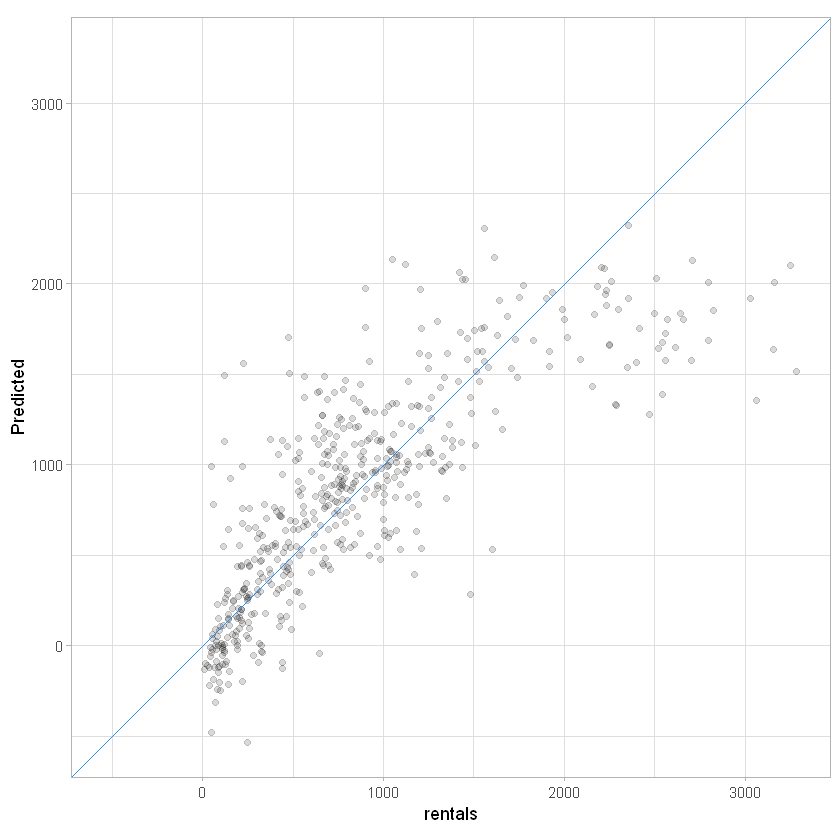

In [8]:
# Visualise resampled results
lr_bike_preds %>% 
  ggplot(aes(x = rentals, y = .pred)) + 
  geom_point(alpha = .15) +
  geom_abline(color = "dodgerblue") + 
  coord_obs_pred() + 
  ylab("Predicted") +
  theme_light()

In [9]:
## Ideally don't run this.
## This is just to prove that with a little preprocessing,
## we can get better modeling results

# Last fit on lr
# lf = lr_wf %>% 
#     last_fit(bike_split)

# lf %>% 
#     collect_metrics()

## Let's try out an xgboost model too


Let's first address a more pressing issue; a boosted tree's hyperparameters:

In [17]:
args(boost_tree)

function (mode = "unknown", engine = "xgboost", mtry = NULL, 
    trees = NULL, min_n = NULL, tree_depth = NULL, learn_rate = NULL, 
    loss_reduction = NULL, sample_size = NULL, stop_iter = NULL) 
NULL

Those are a lot of model arguments: `mtry`, `trees`, `min_n`, `tree_depth`, `learn_rate`, `loss_reduction`, `sample_size`, `stop_iter` 🤯🤯!

Now, this begs the question:

how do we know what values we should use?�
���

This brings us to `model tuning`.

### Tune model hyperparameters

Models have parameters with unknown values that must be estimated in order to use the model for predicting.
These model parameters, correctly referred to as **hyperparameters** or **tuning parameters**, cannot be learned directly from a dataset during model training.
Instead of learning these kinds of hyperparameters during model training, we can *estimate* the *best values* for these by training many models on a `simulated data set` and measuring how well all these models perform.
This process is called **tuning**.

We won't go into the details of each hyperparameter, but they work together to affect the way the algorithm trains a model.
For instance in boosted trees,

-   `min_n` forces the tree to discard any node that has a number of observations below your specified minimum.

-   tuning the value of `mtry` controls the number of variables that will be used at each split of a decision tree.

-   tuning `tree_depth`, on the other hand, helps by restricting our tree from growing after it reaches a certain level.

In many cases, the default values provided by Tidymodels will work well (see the defaults by running `help("boost_tree")` ); but there may be some advantage in modifying hyperparameters to get better predictive performance or reduce training time.

So how do you know what hyperparameter values you should use?
Well, in the absence of a deep understanding of how the underlying algorithm works, you'll need to experiment.
Fortunately, Tidymodels provides a way to *tune* hyperparameters by trying multiple combinations and finding the best result for a given performance metric.

#### Identify tuning parameters.

How can we signal to tidymodels functions which arguments (in our case `cost_complexity`, `tree_depth`, `min_n`) should be optimized?
Parameters are marked for tuning by assigning them a value of `tune()`.

Next let's build our model specification with some tuning and then put our recipe and model specification together in a **`workflow()`**, for ease of use.

In [11]:
# Make a tunable model specification
boost_spec <- boost_tree(trees = 50,
                         tree_depth = tune(),
                         learn_rate = tune()) %>% 
  set_engine('xgboost') %>% 
  set_mode('regression')


# Specify a recipe
bike_recipe <- recipe(rentals ~ ., data = bike_train) %>% 
  step_normalize(all_numeric_predictors()) %>% 
  step_dummy(all_nominal_predictors(), one_hot = TRUE) 


# Bundle a recipe and model spec using a workflow
boost_workflow <- workflow() %>% 
  add_recipe(bike_recipe) %>% 
  add_model(boost_spec)

# Print workflow
boost_workflow

== Workflow ====================================================================
Preprocessor: Recipe
Model: boost_tree()

-- Preprocessor ----------------------------------------------------------------
2 Recipe Steps

* step_normalize()
* step_dummy()

-- Model -----------------------------------------------------------------------
Boosted Tree Model Specification (regression)

Main Arguments:
  trees = 50
  tree_depth = tune()
  learn_rate = tune()

Computational engine: xgboost 


#### Create a tuning grid.

Good job!
Now that we have specified what parameter to tune, we'll need to figure out a set of possible values to try out then choose the best.

In [12]:
# Create a grid of tuning parameters
tree_grid <- grid_regular(tree_depth(),
                  # You can specify hyperparameter ranges too
learn_rate(range = c(0.01, 0.3), trans = NULL), levels = 5)

# Display hyperparameter combinations that will be used for tuning
tree_grid

tree_depth,learn_rate
<int>,<dbl>
1,0.0100
4,0.0100
8,0.0100
11,0.0100
15,0.0100
1,0.0825
4,0.0825
8,0.0825
11,0.0825


The function [`grid_regular()`](https://tidymodels.github.io/dials/reference/grid_regular.html) chooses sensible values to try for each hyperparameter; here, we asked for 5 of each.
Since we have two hyperparameters to tune, `grid_regular()` returns 5×5 = 25 different possible tuning combinations to try in a tidy tibble format.

#### Let's sample our data.

As we pointed out earlier, hyperparameters cannot be learned directly from the training set.
Instead, they are estimated using simulated data sets created from a process called resampling.
One resampling approach is `cross-validation`.

Cross-validation involves taking your training set and randomly dividing it up evenly into `V` subsets/folds.
You then use one of the folds for validation and the rest for training, then you repeat these steps with all the subsets and combine the results, usually by taking the mean.
This is just one round of cross-validation.
Sometimes, to obtain better results, data scientists do this more than once, perhaps 5 times.

In [22]:
set.seed(2056)
# 5 fold CV repeated once
bike_folds <- vfold_cv(data = bike_train, v = 5, repeats = 1)

#### Time to tune

Now, it's time to tune the grid to find out which hyperparameter combination results in the best performance.

In [13]:
# Allow parallel processing
doParallel::registerDoParallel()

# Model tuning via grid search
set.seed(2020)
tree_grid <- tune_grid(
  object = boost_workflow,
  resamples = bike_folds,
  grid = tree_grid
)

#### Visualize tuning results

Now that we have trained models for many possible hyperparameter values, let's explore the results.

As a first step, we'll use the function **`collect_metrics()`** to extract the performance metrics from the tuning results.

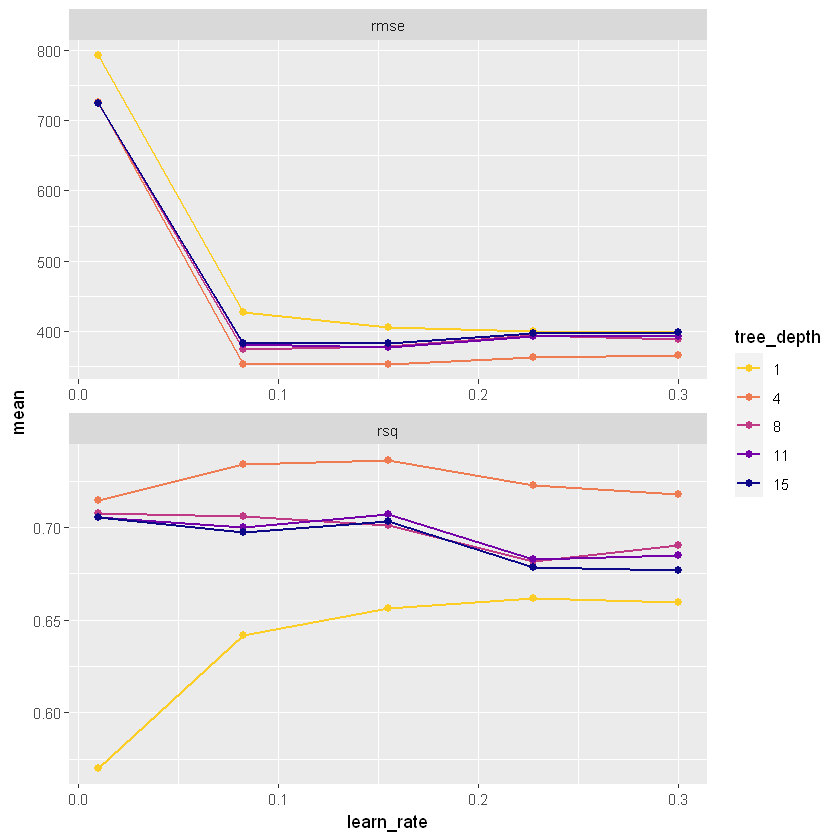

In [14]:
# Visualize the results
tree_grid %>% 
  collect_metrics() %>% 
  mutate(tree_depth = factor(tree_depth)) %>% 
  ggplot(mapping = aes(x = learn_rate, y = mean,
                       color = tree_depth)) +
  geom_line(size = 0.6) +
  geom_point(size = 2) +
  facet_wrap(~ .metric, scales = 'free', nrow = 2)+
  scale_color_viridis_d(option = "plasma", begin = .9, end = 0)

We can see that our "stubbiest" tree, with a depth of 1, is the worst model according to both metrics (rmse, rsq) and across all candidate values of `learn_rate`.
A tree depth of 4 and a learn_rate of around 0.1 seems to do the trick!
Let's investigate these tuning parameters further.
We can use `show_best()` to display the top sub-models and their performance estimates.

In [16]:
tree_grid %>% 
  show_best('rmse')

tree_depth,learn_rate,.metric,.estimator,mean,n,std_err,.config
<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,0.0825,rmse,standard,353.9447,5,19.79369,Preprocessor1_Model07
4,0.1550,rmse,standard,354.1398,5,19.43109,Preprocessor1_Model12
4,0.2275,rmse,standard,364.0215,5,16.75086,Preprocessor1_Model17
4,0.3000,rmse,standard,366.0967,5,14.21286,Preprocessor1_Model22
8,0.0825,rmse,standard,375.4801,5,19.50562,Preprocessor1_Model08


We can then use `select_best()` to find the tuning parameter combination with the best performance values.

We can then use `select_best()` to find the tuning parameter combination with the best performance values.

In [17]:
# Select the tree with the best RMSE
best_tree <- tree_grid %>% 
  select_best('rmse')

# Display best tree
best_tree

tree_depth,learn_rate,.config
<int>,<dbl>,<chr>
4,0.0825,Preprocessor1_Model07


Compared with the linear regression model, the boosted trees model seems to be performing better. Let's go ahead with it.

We have used resamples to compare and evealuate models and narrow down on which one we'll use in the train and test sets. Let's finalize the boosted trees model.

### Finalizing our model

Now that we have the best performance values, we can use `tune::finalize_workflow()` to update (or "finalize") our workflow object with the best estimate values for tree_depth and learn_rate.

In [18]:
# Update workflow
final_wf <- boost_workflow %>% 
  finalize_workflow(best_tree)

# Print final workflow
final_wf

== Workflow ====================================================================
Preprocessor: Recipe
Model: boost_tree()

-- Preprocessor ----------------------------------------------------------------
2 Recipe Steps

* step_normalize()
* step_dummy()

-- Model -----------------------------------------------------------------------
Boosted Tree Model Specification (regression)

Main Arguments:
  trees = 50
  tree_depth = 4
  learn_rate = 0.0825

Computational engine: xgboost 


Our tuning is done!
🥳 We have updated our workflow with the best estimated hyperparameter values!

#### The last fit: back to our test set.

Finally, let's return to our test data and estimate the model performance we expect to see with new data.
We can use the function [`last_fit()`](https://tidymodels.github.io/tune/reference/last_fit.html) with our finalized model; this function *fits* the finalized model on the full training data set and *evaluates* the finalized model on the testing data.

In [19]:
# Make a last fit
final_fit <- final_wf %>% 
  last_fit(bike_split)


# Collect metrics
final_fit %>% 
  collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,288.59728,Preprocessor1_Model1
rsq,standard,0.83032,Preprocessor1_Model1


How's that for a tune 🎶 ​💃​🕺​​​!
Also, there seems to be some improvement in the evaluation metrics compared to using the default values for *learn_rate* and *tree_depth* hyperparameters.
Now, we leave it to you to explore how tuning the other hyperparameters affects the model performance.

We've now seen a number of common techniques used to train predictive models for regression.
In a real project, you'd likely try a few more algorithms, hyperparameters, and preprocessing transformations; but by now you should have got the general idea of the procedure to follow.
You can always explore the [reference docs](https://www.tidymodels.org/find/parsnip/#models), or use the `args()` function to see which parsnip object arguments are available.

> See this [Tidymodels reference page](https://www.tidymodels.org/find/parsnip/#models) to explore model types and engines and to explore model arguments.

Let's now explore how you can use the trained model with new data.

### Use the Trained Model

We'll begin by saving our model but first, let's extract the *trained workflow* object from `final_fit` object.

In [ ]:
# Extract trained workflow
bike_boost_model <- final_fit %>% 
  extract_workflow()

Now, we can save this model to be used later.

In [ ]:
# Save trained workflow
saveRDS(bike_boost_model, 'bike_boost_model.rds')

Now, we can load it whenever we need it, and use it to predict labels for new data.
This is often called *`scoring`* or *`inferencing`*.

For example, lets try and predict some values from our test set using the saved model.

In [ ]:
# Load the model
loaded_model <- readRDS("bike_boost_model.rds")

# Extract predictors
bike_new <- bike_test %>% 
  dplyr::slice(5:9)

# Use the model to predict rentals
results <- loaded_model %>% 
  augment(bike_new)

# See model predictions 
results

PeRfect!
All is well that ends with a working model, time to end the cycle **🚴**!

### **Summary**

That concludes the notebooks for this module on regression.
In this notebook we ran a complex regression, tuned it, saved the model, and used it to predict outcomes for the future.

### **Further Reading**

To learn more about Tidymodels, see the [Tidymodels documentation](https://www.tidymodels.org/).